# Работу выполнил студенты группы 09-122 Визель Леонид Александрович и Кучаев Ринат Загирович

# ГЛАВА 8 

## Интегрирование

В этой главе мы рассмотрим различные аспекты интегрирования, уделяя основное внимание численному интегрированию. По историческим причинам численное интегрирование также известно как квадратура. Интегрирование значительно сложнее, чем обратная операция дифференцирования — и хотя существует множество примеров интегралов, которые можно вычислить аналитически, в основном приходится прибегать к численным методам. В зависимости от свойств подынтегральной функции (интегрируемой функции) и пределов интегрирования численное вычисление интеграла может быть простым или трудным. Интегралы от непрерывных функций и с конечными пределами интегрирования в большинстве случаев могут быть эффективно вычислены в одном измерении, но интегрируемые функции с особенностями или интегралы с бесконечными пределами интегрирования являются примерами случаев, которые может быть трудно обработать численно даже в одном измерении. Двумерные интегралы (двойные интегралы) и интегралы более высокого порядка можно вычислять численно с помощью повторного одномерного интегрирования или с использованием методов, которые являются многомерным обобщением методов, используемых для решения одномерных интегралов. Однако сложность вычислений быстро растет с увеличением числа измерений, по которым необходимо интегрировать, и на практике такие методы применимы только для низкоразмерных интегралов, таких как двойные или тройные интегралы. Интегралы более высокой размерности часто требуют совершенно других методов, таких как алгоритмы выборки Монте-Карло.

Помимо численного вычисления интегралов с определенными пределами интегрирования, дающего в результате одно число, интегрирование имеет и другие важные приложения. Например, уравнения, в которых подынтегральной функцией интеграла является неизвестная величина, называются интегральными уравнениями, и такие уравнения часто встречаются в научных и инженерных приложениях. Интегральные уравнения обычно трудно решить, но их часто можно преобразовать в системы линейных уравнений путем дискретизации интеграла. Однако здесь мы не рассматриваем эту тему, а примеры задач такого типа увидим в главе 10. Еще одним важным применением интегрирования являются интегральные преобразования, которые
— это методы преобразования функций и уравнений между различными областями. В конце этой главы мы кратко обсудим, как SymPy можно использовать для вычисления некоторых интегральных преобразований, таких как преобразования Лапласа и преобразования Фурье.

Для выполнения символьного интегрирования мы можем использовать SymPy, как кратко обсуждалось в главе 3, а для вычисления числового интегрирования мы в основном используем модуль Integration в SciPy. Однако в SymPy (через библиотеку множественной точности mpmath) также есть процедуры численного интегрирования, которые дополняют процедуры в SciPy, например, предлагая интеграцию произвольной точности. В этой главе мы рассмотрим оба этих варианта и обсудим их плюсы и минусы. Мы также кратко рассмотрим интеграцию Монте-Карло с использованием библиотеки scikit-monaco.

Scikit-monaco — это небольшая недавно выпущенная библиотека, которая делает интегрирование Монте-Карло удобным и легко доступным. На момент написания актуальная версия scikit-monaco — это 0.2.1. См. http://scikit-monaco.readthedocs.org для получения дополнительной информации.

## Импорт модулей

В этой главе нам, как обычнопо, требуются библиотеки NumPy и Matplotlib для базовой поддержки чисел и графиков, а кроме того, мы используем модуль интеграции из SciPy, библиотеку SymPy и математическую библиотеку произвольной точности mpmath. Здесь мы предполагаем, что эти модули импортируются следующим образо



In [42]:
import numpy as np

In [43]:
import matplotlib.pyplot as plt

In [44]:
import matplotlib as mpl

In [45]:
from scipy import integrate

In [46]:
import sympy

In [47]:
import mpmath

Кроме того, для корректного форматирования вывода SymPy нам также необходимо настроить его систему печати:

In [48]:
sympy.init_printing()

## Численные методы интегрирования

Здесь нас интересует вычисление определенных интегралов вида $I(f)=\int_{a}^{b} f(x) \mathrm{d} x$ с заданными пределами интегрирования $a$ и $b$. Интервал $[a, b]$ может быть конечным, полубесконечным (где либо $a=-\infty$, либо $b=\infty$ ) или бесконечным (где оба $a=-\infty$ и $b =\infty$ ). Интеграл $I(f)$ можно интерпретировать как площадь между кривой подынтегральной функции $f(x)$ и осью $x$, как показано на рисунке 8-1.

![](SZE-1.jpg)

Рисунок 8-1. Интерпретация интеграла как площади между кривой подынтегрального выражения и осью $x$, где площадь считается положительной, если $f(x)>0$ (зеленый/светлый), и отрицательной в противном случае (красный/темный).

Общая стратегия численного вычисления интеграла $I(f)$ в приведенной выше форме состоит в том, чтобы записать интеграл в виде дискретной суммы, аппроксимирующей значение интеграл получаем

$$
I(f)=\sum_{i=1}^{n} w_{i} f\left(x_{i}\right)+r_{n}
$$

Здесь $w_{i}$ — веса $n$ оценок $f(x)$ в точках $x_{i} \in[a, b]$, а $r_{n}$ — причитающаяся невязка к приближению. На практике мы предполагаем, что $r_{n}$ мал и им можно пренебречь, но важно иметь оценку $r_{n}$, чтобы знать, насколько точно аппроксимируется интеграл. Эта формула суммирования $I(f)$ известна как $n$-точечное квадратурное правило, а выбор числа точек $n$, их расположения в $[a, b]$ и весовых коэффициентов $ w_{i}$ влияет на точность и вычислительную сложность его оценки. Правила квадратур могут быть получены путем интерполяции $f(x)$ на интервале $[a, b]$. Если точки $x_{i}$ равномерно распределены в интервале $[a, b]$ и используется полиномиальная интерполяция, то полученное квадратурное правило известно как правило Ньютона-Котеса.
правило квадратуры. Например, аппроксимируя $f(x)$ полиномом нулевого порядка (постоянное значение) с использованием среднего значения $x_{0}=(a+b) / 2$, получаем

$$
\int_{a}^{b} f(x) \mathrm{d} x \approx f\left(\frac{a+b}{2}\right)_{a}^{b} \mathrm{~d} x=(b-a) f\left(\frac{a+b}{2}\right)
$$

Это известно как правило средней точки, и оно интегрирует полиномы до первого порядка (линейные функции) точно, и поэтому говорят, что оно имеет полиномиальную степень один. Аппроксимация $f(x)$ полиномом первой степени, оцениваемым в конечных точках интервала, приводит к

$$
\int_{a}^{b} f(x) \mathrm{d} x \approx \frac{b-a}{2}(f(a)+f(b))
$$

Это известно как правило трапеций, и оно также имеет первую полиномиальную степень. Использование интерполяционного полинома второго порядка приводит к правилу Симпсона:

$$
\int_{a}^{b} f(x) \mathrm{d} x \approx \frac{b-a}{6}\left(f(a)+4 f\left(\frac{a+b}{2}\right)+f(b)\right)
$$

который использует оценки функций в конечных точках и средней точке. Этот метод имеет полиномиальную степень три, что означает, что он интегрирует ровно полиномы до третьего порядка. Метод получения этой формулы можно легко продемонстрировать с помощью SymPy: сначала мы определяем символы для переменных $a, b$ и $x$, а также функции $f$.

In [49]:
a, b, X = sympy.symbols("a, b, X")

In [50]:
f = sympy.Function("f")

Далее мы определяем кортеж $x$, который содержит точки выборки (концы и середину интервала $[a, b])$ и список $\mathrm{w}$ весовых коэффициентов, которые будут использоваться в квадратуре правило, соответствующее каждой точке отбора проб:

In [51]:
x= a, (a+b)/2, b # for Simpson's rule

In [52]:
w = [sympy.symbols("w_\%d" % i) for i in range(len(x))]

Учитывая $x$ и $w$, теперь мы можем построить символическое выражение для правила квадратур:

In [53]:
q_rule = sum([w[i] * f(x[i]) for i in range(len(x))])

In [54]:
q_rule

                  ⎛a   b⎞            
w_\0⋅f(a) + w_\1⋅f⎜─ + ─⎟ + w_\2⋅f(b)
                  ⎝2   2⎠            

Для вычисления соответствующих значений весовых коэффициентов $w_{i}$ мы выбираем полиномиальные базисные функции $\left\{\phi_{n}(x)=x^{n}\right\}_{n=0 }^{2}$ для интерполяции $f(x)$, и здесь мы используем Sympy. Лямбда-функция для создания символических представлений для каждой из этих базисных функций:

In [55]:
phi = [sympy.Lambda(X, X**n) for n in range(len(x))]

In [56]:
phi

Ключом к нахождению весовых коэффициентов в квадратурном выражении является то, что интеграл $\int_{a}^{b} \phi_{n}(x) \mathrm{d} x$ может быть вычислен аналитически для каждой из базисных функций. $\phi_{n}(x)$. Подставив в квадратурное правило функцию $f(x)$ на каждую из базисных функций $\phi_{n}(x)$, получим систему уравнений для неизвестных весовых коэффициентов:

$$
\sum_{i=0}^{2} w_{i} \phi_{n}\left(x_{i}\right)=\int_{a}^{b} \phi_{n}(x) \mathrm{d} x
$$

Эти уравнения эквивалентны требованию, чтобы правило квадратур точно интегрировало все базисные функции и, следовательно, (по крайней мере) все функции, натянутые на базис. Эту систему уравнений можно построить с помощью SymPy, используя

In [57]:
eqs = [q_rule.subs(f, phi[n]) - sympy.integrate(phi[n](X), (X,a,b))
          for n in range(len(phi))]

Решение этой системы линейных уравнений дает аналитические выражения для весовых коэффициентов:

In [58]:
w_sol = sympy.solve(eqs, w)

In [59]:
w_sol

⎧        a   b          2⋅a   2⋅b          a   b⎫
⎨w_\0: - ─ + ─, w_\1: - ─── + ───, w_\2: - ─ + ─⎬
⎩        6   6           3     3           6   6⎭

подставив решение в символьное выражение правила квадратур, получим:

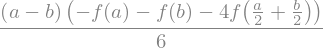

In [60]:
q_rule.subs(w_sol).simplify()

Мы признаем этот результат как квадратурное правило Симпсона, данное в предыдущем разделе. Выбор разных точек выборки (кортеж $x$ в этом коде) приводит к различным правилам квадратур.

Квадратурные правила более высокого порядка можно аналогичным образом получить с помощью полиномиальной интерполяции более высокого порядка (больше точек выборки в интервале $[a, b]$). Однако полиномиальная интерполяция высокого порядка может иметь нежелательное поведение между точками выборки, как обсуждалось в главе 7. Поэтому вместо использования квадратурных правил более высокого порядка часто лучше разделить интервал интегрирования $[a, b]$ на подинтервалы. $\left[a=x_{0}, x_{1}\right],\left[x_{1}, x_{2}\right], \ldots,\left[x_{N-1}, x_{ N}=b\right]$ и используйте квадратурное правило низкого порядка на каждом из этих подинтервалов. Такие методы известны как составные квадратурные правила. На рисунке 8-2 показаны три квадратурных правила Ньютона-Котеса низшего порядка для функции $f(x)=3+x+x^{2}+x^{3}+x^{4}$ на интервале $. [-1,1]$ и соответствующие составные правила квадратур с четырьмя подразделениями исходного интервала.

![](SZE-2.jpg)

Рисунок 8-2. Визуализация правил квадратур (верхняя панель) и составных правил квадратур (нижняя панель) нулевого порядка (правило средней точки), первого (правило трапеции) и второго (правило Симпсона)

Важным параметром, характеризующим составные квадратурные правила, является длина подинтервала $h=(b-a)/N$. Оценки ошибок в приближенном правиле квадратур и масштабирование ошибки по $h$ можно получить путем разложения подынтегрального выражения в ряд Тейлора и аналитического интегрирования члена в полученный ряд. Альтернативный метод состоит в одновременном рассмотрении правил квадратур разных порядков или разной длины подинтервалов $h$. Часто можно показать, что разница между двумя такими результатами дает оценку ошибки, и это является основой того, сколько квадратурных процедур дают оценку ошибки в дополнение к оценке интеграла, как мы увидим в примерах ниже.

Мы видели, что квадратурные правила Ньютона-Котеса используют равномерно расположенные точки выборки подынтегральной функции $f(x)$. Это часто удобно, особенно если подынтегральная функция получается из измерений или наблюдений в заданных точках и не может быть вычислена в произвольных точках интервала $[a, b]$. Однако это не обязательно самый эффективный выбор квадратурных узлов, и если подынтегральная функция задана как функция, которую легко можно вычислить при произвольных значениях $x \in[a, b]$, то может быть выгодно использовать правила квадратур, которые не используют равномерно расположенные точки выборки. Примером такого метода является квадратура Гаусса, которая также использует полиномиальную интерполяцию для определения значений весовых коэффициентов в правиле квадратур, но где квадратурные узлы $x_{i}$ выбираются так, чтобы максимизировать порядок полиномов, которые можно точно проинтегрировать. (степень полинома) при фиксированном количестве квадратурных точек. Оказывается, что варианты $x_{i}$, удовлетворяющие этим критериям, являются корнями различных ортогональных полиномов, а точки выборки $x_{i}$ обычно располагаются в иррациональных местах интервала интегрирования $[a, b]$ . Обычно это не является проблемой для численных реализаций, но на практике это требует, чтобы функция $f(x)$ была доступна для оценки в произвольных точках, которые определяются процедурой интегрирования, а не задавались в виде табличных или заранее вычисленных данных с регулярными интервалами. значения $x$. Правила квадратуры Гаусса обычно более эффективны, если $f(x)$ можно оценить при произвольных значениях, но по только что упомянутой причине квадратурные правила Ньютона-Котеса также имеют важные случаи использования, когда подынтегральная функция задается в виде табличных данных.

## Численная интеграция с SciPy

Числовые квадратурные процедуры в модуле интеграции SciPy можно разделить на два типа: процедуры, которые принимают подынтегральное выражение как функцию Python, и процедуры, которые принимают массивы с выборками подынтегрального выражения в заданных точках. В функциях первого типа используются квадратуры Гаусса (quad,квадратура,fixed_quad), а в функциях второго типа — методы Ньютона-Котеса (trapz, simps и romb).

Квадратурная функция — это адаптивная квадратурная процедура Гаусса, реализованная на Python. Квадратура неоднократно вызывает функцию fix_quad для гауссовой квадратуры фиксированного порядка с возрастанием порядка, пока не будет достигнута требуемая точность. Функция Quad — это оболочка для подпрограмм из библиотеки FORTRAN QUADPACK, которая имеет превосходную производительность с точки зрения скорости и имеет больше возможностей (например, поддержку бесконечных пределов интегрирования). Поэтому обычно предпочтительнее использовать квадратурную функцию, и в дальнейшем мы будем использовать эту квадратурную функцию. Однако все эти функции принимают схожие аргументы и часто могут быть заменены друг другом. В качестве первого аргумента они принимают функцию, реализующую подынтегральную функцию, а второй и третий аргументы — нижний и верхний пределы интегрирования. В качестве конкретного примера рассмотрим численное вычисление интеграла $\int_{-1}^{1} e^{-x^{2}} \mathrm{~d} x$. Чтобы вычислить этот интеграл с помощью функции Quad SciPy, мы сначала определяем функцию для подынтегральной функции, а затем вызываем функцию Quad:

In [61]:
def f(x):
    return np.exp(-x**2)

In [62]:
val, err = integrate.quad(f,-1,1)